# Exploring Homesite Data (WORK IN PROGRESS)
> Exploring Homesite Data in Collab

- toc: true 
- badges: true
- comments: true
- categories: [kaggle]
- author: Nissan Dookeran
- image: images/chart-preview.png

## Introduction

Here I will do some exploratory data analysis of Homesite Data from the Kaggle Competition using Google Colab

## Setup fastai and Google drive

In [1]:
!pip install -Uqq fastai


In [2]:
from fastai.tabular.all import *

The snippet below is only useful in Colab for accessing my Google Drive and is straight out the [fastbook source code in Github](https://github.com/fastai/course20/blob/master/fastbook/__init__.py) 

In [3]:
global gdrive
gdrive = Path('/content/gdrive/My Drive')
from google.colab import drive
if not gdrive.exists(): drive.mount(str(gdrive.parent))

> Add the Kaggle bits

In [4]:
!pip install kaggle

In [5]:
!ls /content/gdrive/MyDrive/Kaggle/kaggle.json

/content/gdrive/MyDrive/Kaggle/kaggle.json


Useful links here:
- Documentation on [Path library](https://docs.python.org/3/library/pathlib.html#basic-use)
- Documentation on [fastai extensions to Path library](https://fastcore.fast.ai/xtras.html#Extensions-to-Pathlib.Path)

In [6]:
Path.cwd()

Path('/content')

## Setup kaggle environment

In [7]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
from kaggle import api

In [9]:
path = Path.cwd()
path.ls()

(#3) [Path('/content/.config'),Path('/content/sample_data'),Path('/content/gdrive')]

In [10]:
path = path/"gdrive/MyDrive/Kaggle/homesite_data"
path.mkdir(exist_ok=True)
Path.BASE_PATH = path
api.competition_download_cli('homesite-quote-conversion', path=path)
file_extract(path/"homesite-quote-conversion.zip")
file_extract(path/"train.csv.zip")
file_extract(path/"test.csv.zip")

homesite-quote-conversion.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
path

Path('.')

In [12]:
path.ls()

(#6) [Path('homesite-quote-conversion.zip'),Path('sample_submission.csv.zip'),Path('test.csv.zip'),Path('train.csv.zip'),Path('train.csv'),Path('test.csv')]

## Exploring the Homesite data

In [13]:
df_train = pd.read_csv(path/"train.csv", low_memory=False)
df_train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,17,23,17,23,15,22,16,22,13,22,13,23,T,D,2,1,7,18,3,8,0,5,5,24,V,48649,0,0,0,0,...,8,4,20,22,10,8,6,5,15,13,19,18,16,14,21,23,21,23,16,11,22,24,7,14,-1,17,15,17,14,18,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,6,8,6,8,5,7,5,8,13,22,13,23,T,E,5,9,5,14,6,18,1,5,5,11,P,26778,0,0,1,1,...,23,24,11,15,21,24,6,11,21,21,18,15,20,20,13,12,12,12,15,9,13,11,11,20,-1,9,18,21,8,7,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,7,12,7,12,6,10,7,11,25,25,13,23,T,J,4,6,3,10,4,11,1,5,5,11,K,8751,0,0,2,2,...,21,22,24,25,20,22,7,13,23,23,20,19,20,20,18,20,19,21,20,19,11,8,3,3,-1,5,21,24,12,15,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,3,2,3,2,2,2,3,2,13,22,13,23,Y,F,15,23,8,19,14,24,0,5,5,23,V,43854,0,0,0,0,...,3,1,14,22,6,2,7,14,11,8,19,18,18,16,13,12,13,12,17,13,5,2,3,4,-1,7,14,14,14,18,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,8,13,8,13,7,11,7,13,13,22,13,23,T,F,4,6,3,6,3,6,1,5,5,7,R,12505,1,0,0,0,...,24,25,9,11,25,25,5,3,22,22,21,21,17,15,25,25,25,25,17,13,13,11,3,4,-1,7,11,9,10,10,18,22,-1,10,-1,11,-1,12,N,IL


In [14]:
df_test = pd.read_csv(path/"test.csv", low_memory=False)
df_test.head()

,QuoteNumber,Original_Quote_Date,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,0.9364,0.0006,"1,487",1.3045,N,4,4,4,4,3,3,3,4,13,22,13,23,Y,K,13,22,6,16,9,21,0,5,5,11,P,67052,0,0,0,0,0,...,22,23,9,12,25,25,6,9,4,2,16,12,20,20,2,2,2,1,1,1,10,7,25,25,-1,19,19,22,12,15,1,1,-1,1,-1,20,-1,25,Y,IL
1,5,2013-09-07,F,11,0.9919,0.0038,564,1.1886,N,8,14,8,14,7,12,8,13,13,22,13,23,T,E,4,5,3,6,3,6,1,5,5,4,R,27288,1,0,0,0,0,...,23,24,12,21,23,25,7,11,16,14,13,6,17,15,7,5,7,5,13,7,14,14,7,14,-1,4,1,1,5,3,10,10,-1,5,-1,5,-1,21,N,NJ
2,7,2013-03-29,F,15,0.8945,0.0038,564,1.0670,N,11,18,11,18,10,16,10,18,13,22,13,23,T,E,3,3,5,14,3,9,1,5,5,23,V,65264,0,1,2,2,0,...,16,18,9,10,14,16,6,8,20,19,17,14,16,13,20,22,20,22,20,18,10,7,4,7,-1,11,13,12,18,22,10,11,-1,20,-1,22,-1,11,N,NJ
3,9,2015-03-21,K,21,0.8870,0.0004,"1,113",1.2665,Y,14,22,15,22,13,20,22,25,13,22,13,23,Y,F,5,9,9,20,5,16,1,5,5,11,R,32725,1,1,1,1,0,...,11,11,9,10,11,13,15,21,14,12,17,13,10,6,20,22,20,22,19,16,12,11,4,6,-1,13,10,8,5,3,8,8,-1,13,-1,8,-1,21,N,TX
4,10,2014-12-10,B,25,0.9153,0.0007,935,1.0200,N,4,5,4,5,4,4,4,5,13,22,13,23,Y,D,12,21,1,1,3,6,0,5,5,11,T,56025,0,1,1,1,0,...,9,8,25,25,9,3,9,18,7,4,16,12,13,9,8,6,8,6,11,5,19,21,13,21,-1,23,11,8,5,3,7,7,-1,3,-1,22,-1,21,N,CA


In [15]:
y_column = df_train.columns.difference(df_test.columns)

In [16]:
y_column

Index(['QuoteConversion_Flag'], dtype='object')

From this it looks like `QuoteConversion_Flag` is the value we want to predict. Let's take a look at this

In [17]:
type(df_train.QuoteConversion_Flag)

pandas.core.series.Series

In [18]:
df_train.QuoteConversion_Flag.unique()

array([0, 1])

In [19]:
type(df_train.QuoteConversion_Flag.unique()[0])

numpy.int64

What's interesting here is that the training data outcomes that we want to generate predictions on seems to just be a binary classification, either there's a sale (1) or there's no sale (0). 
With maths and rounding up and down, predictions above 50% will be rounded up to a sale and predictions less than 50% will be classified as predicting no sale if we keep this field as an integer. 

In reality, 50% might not be a good threshold to keep and we may want to vary this rounding value of confidence.
If we convert it to a floating point, we can have more control over this threshold, and thus the final prediction, so we can predict a sale if there's say, more than 90% confidence in the prediction.

In [20]:
df_train.QuoteConversion_Flag = df_train.QuoteConversion_Flag.astype(dtype='float64')

## First things first 
Learning from [my collague Tim's work](https://redditech.github.io/team-fast-tabulous/jupyter/2021/06/20/Identify-problem-type.html) already we know:
- `Quotenumber` is unique so make it the index
- `Original_Quote_Date` should be made into a date

Additionally, we should make sure to apply any changes to data types to both train and test data so predictions don't fail later on


In [21]:
df_train = df_train.set_index('QuoteNumber')
df_test = df_test.set_index('QuoteNumber')

In [22]:
df_train['Original_Quote_Date'] = pd.to_datetime(df_train['Original_Quote_Date'])
df_test['Original_Quote_Date'] = pd.to_datetime(df_train['Original_Quote_Date'])

## Goal: Identifying our categorical and continuous data columns

In [23]:
categorical=L()
continuous=L()
notused =L()

### Dividing up the data into manageable chunks for exploration

Let's now see how many columns we are working with

In [24]:
df_train.columns

Index(['Original_Quote_Date', 'QuoteConversion_Flag', 'Field6', 'Field7',
       'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'CoverageField1A',
       ...
       'GeographicField59A', 'GeographicField59B', 'GeographicField60A',
       'GeographicField60B', 'GeographicField61A', 'GeographicField61B',
       'GeographicField62A', 'GeographicField62B', 'GeographicField63',
       'GeographicField64'],
      dtype='object', length=298)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260753 entries, 1 to 434588
Columns: 298 entries, Original_Quote_Date to GeographicField64
dtypes: datetime64[ns](1), float64(7), int64(263), object(27)
memory usage: 604.8+ MB


298 columns is alot, let's split these by type

In [26]:
df_train.dtypes.unique()

array([dtype('<M8[ns]'), dtype('float64'), dtype('O'), dtype('int64')],
      dtype=object)

### Exploring the float64 data

Let's take a look at the smallest subset, the floating point columns, to see if there's anything interesting about them

In [27]:
(df_train[df_train.columns[df_train.dtypes=='float64']].drop(columns=['QuoteConversion_Flag'])).head()

,Field8,Field9,Field11,PersonalField84,PropertyField25,PropertyField29
QuoteNumber,,,,,,
1,0.9403,0.0006,1.0200,2.0,3.0,0.0
2,1.0006,0.0040,1.2433,NaN,2.0,NaN
4,1.0006,0.0040,1.2433,NaN,1.5,NaN
6,0.9769,0.0004,1.2665,NaN,1.0,NaN
8,0.9472,0.0006,1.3045,2.0,3.0,0.0


Referencing [this article](https://towardsdatascience.com/exploratory-data-analysis-eda-visualization-using-pandas-ca5a04271607) for some good tips on EDA (Exploratory Data Analysis)

In [28]:
(df_train[df_train.columns[df_train.dtypes=='float64']].drop(columns=['QuoteConversion_Flag'])).describe()

,Field8,Field9,Field11,PersonalField84,PropertyField25,PropertyField29
count,260753.000000,260753.000000,260753.000000,136545.000000,260753.000000,60068.000000
mean,0.938346,0.001451,1.162718,1.990142,1.632422,0.000200
std,0.037086,0.001486,0.116833,0.127931,0.717064,0.014133
min,0.874600,0.000400,1.000000,1.000000,0.000000,0.000000
25%,0.915300,0.000600,1.020000,2.000000,1.000000,0.000000
50%,0.940300,0.000600,1.188600,2.000000,1.500000,0.000000
75%,0.968500,0.003800,1.266500,2.000000,2.000000,0.000000
max,1.010100,0.004000,1.304500,8.000000,7.000000,1.000000


#### Field8 analysis

In [29]:
df_train['Field8'].value_counts()

0.9403    48161
0.9153    44198
0.8870    18476
1.0006    18371
0.9919    16845
0.8928    13945
0.8922    10982
0.9691     8237
0.9392     7235
1.0101     6927
0.9838     5178
0.9108     4827
0.9313     4816
1.0005     3436
0.9769     3329
0.9497     3241
0.9472     3175
0.9566     3065
0.9559     2824
0.8793     2697
0.9685     2558
0.9219     2366
0.9368     2238
0.9223     2210
0.8945     2166
0.9023     2036
0.9487     2012
0.9525     1972
0.9482     1835
0.8746     1806
0.9893     1685
0.9258     1280
0.8930     1213
0.9194     1205
0.9364     1189
0.9375     1108
0.9485      969
0.9489      940
Name: Field8, dtype: int64

In [30]:
df_train['Field8'].isna().sum()

0

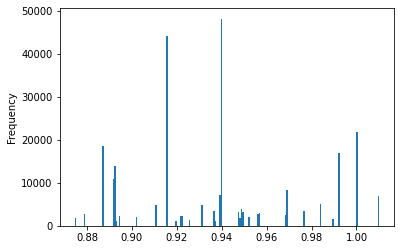

In [31]:
df_train["Field8"].plot.hist(bins=200)

`Field8` looks like a good candidate as a continuous field. Let's add it to that list

In [32]:
continuous.append('Field8')

In [33]:
continuous

(#1) ['Field8']

#### Field 9 analysis

In [34]:
df_train["Field9"].value_counts()

0.0006    74096
0.0004    65011
0.0007    52353
0.0040    39065
0.0038    30228
Name: Field9, dtype: int64

In [35]:
df_train["Field9"].isna().sum()

0

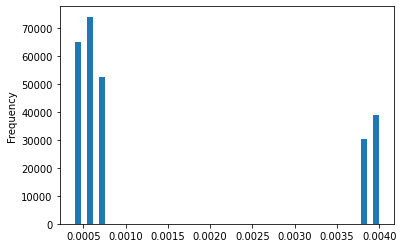

In [36]:
df_train["Field9"].plot.hist(bins=50)

Even though it is a floating point field, it looks very categorical in nature rather than continuous. We *could* peak at the test dataset to confirm this

In [37]:
df_test[~df_test["Field9"].isin(df_train["Field9"].unique())].value_counts()

Series([], dtype: int64)

So this hypothesis holds true, so we're going with the assumption that `Field9` is categorical not continuous

In [38]:
categorical.append("Field9")

In [39]:
df_train["Field9"].unique()

array([0.0006, 0.004 , 0.0004, 0.0007, 0.0038])

#### Field11

In [40]:
df_train["Field11"].value_counts()

1.0200    92359
1.2665    62187
1.3045    28378
1.1886    27646
1.2433    23492
1.2694     6927
1.0670     6412
1.1161     4816
1.2714     3346
1.2392     2824
1.0000     2366
Name: Field11, dtype: int64

In [41]:
df_train["Field11"].isna().sum()

0

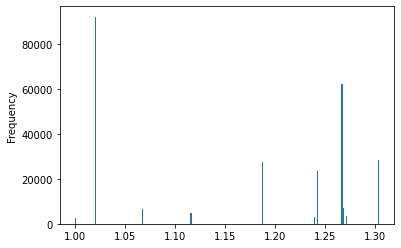

In [42]:
df_train["Field11"].plot.hist(bins=200)

Like `Field9` this too also looks more categorical than continuous in nature. We can help reassure this hypothesis by again "peeking" to see if any test data values don't confirm to this theory

In [43]:
df_test[~df_test["Field11"].isin(df_train["Field11"].unique())].value_counts()

Series([], dtype: int64)

Once again, the hypothesis holds true, so let's add `Field11` to our list of categorical fields

In [44]:
categorical.append("Field11")

#### PersonalField84

In [45]:
df_train["PersonalField84"].value_counts()

2.0    134906
1.0      1564
5.0        62
3.0         7
7.0         3
4.0         2
8.0         1
Name: PersonalField84, dtype: int64

In [46]:
df_train["PersonalField84"].isna().sum()

124208

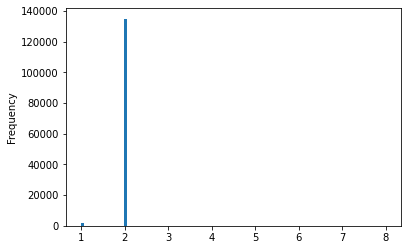

In [47]:
df_train["PersonalField84"].plot.hist(bins=100)

This one also seems a bit categorical. But there are quite a few NA values. We have a few choices here.
- Given the heavy skewing towards one value, it would arguably be a good assumption to fill this with the `mode` value and not a `mean` value.
- Given that a significant number of NA is present, we could ignore it totally as part of our model, and revisit it after if we're looking to fine tune our input dataset
- For now, let's ignore it

In [48]:
notused.append("PersonalField84")

#### PropertyField25

In [49]:
df_train["PropertyField25"].value_counts()

1.0    121563
2.0     91666
3.0     27427
1.5     16003
2.5      2173
5.0      1045
4.0       531
3.5       156
7.0       119
6.0        53
0.0        17
Name: PropertyField25, dtype: int64

In [50]:
df_train["PropertyField25"].isna().sum()

0

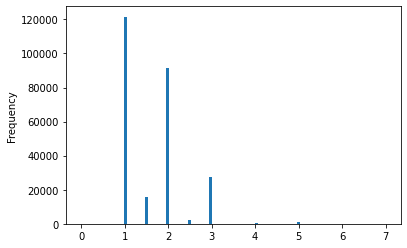

In [51]:
df_train["PropertyField25"].plot.hist(bins=100)

This also looks very much like a categorical field and not a continuous field. "Peeking" once more at our test data to help the belief we're not making a bad assumption here

In [52]:
df_test[~df_test["PropertyField25"].isin(df_train["PropertyField25"].unique())].value_counts()

Series([], dtype: int64)

Once again, the hypothesis holds true, so let's add `PropertyField25` to our list of categorical fields

In [53]:
categorical.append("PropertyField25")

#### PropertyField29

`PropertyField29` looks like it might be a boolean. Let's test this

In [54]:
df_train['PropertyField29'].value_counts()

0.0    60056
1.0       12
Name: PropertyField29, dtype: int64

In [55]:
df_train['PropertyField29'].isna().sum()

200685

This one also seems a bit categorical. But there are quite a few NA values. We have a few choices here.
- Given the heavy skewing towards one value, it would arguably be a good assumption to fill this with the `mode` value and not a `mean` value.
- Given that a significant number of NA is present, we could ignore it totally as part of our model, and revisit it after if we're looking to fine tune our input dataset
- For now, let's ignore it

In [56]:
notused.append("PropertyField29")

##### Experimenting with correlation bits

What if we decided instead we wanted to include this data, with assumptions for values in NA, as part of our model? 

How do we fill the NA values? 

Should we use 0 or should we use 1? 

Let's first look at if it correlates with any other field that might give us insight about how to treat with it

Let's have a look at the ranges in each of these columns, to identify if they're continuous or categorical in nature. [Reference](https://stackoverflow.com/questions/34896455/how-to-do-pearson-correlation-of-selected-columns-of-a-pandas-data-frame)

In [60]:
correlations = df_train.corr()['PropertyField29'][:-1].sort_values(kind="quicksort")
print(correlations)

Field7               -0.739375
PersonalField15      -0.041584
PersonalField33      -0.033010
PersonalField32      -0.025723
SalesField4          -0.023916
                        ...   
PersonalField72            NaN
PersonalField73            NaN
PropertyField6             NaN
GeographicField10A         NaN
GeographicField10B         NaN
Name: PropertyField29, Length: 269, dtype: float64


In [61]:
df_train[['PropertyField29','Field7']].head()

,PropertyField29,Field7
QuoteNumber,,
1,0.0,23
2,NaN,7
4,NaN,7
6,NaN,10
8,0.0,23


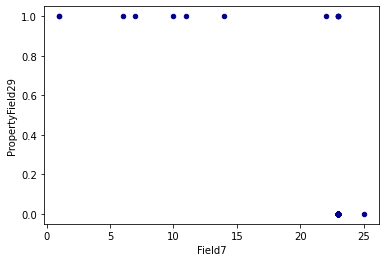

In [62]:
df_train[['PropertyField29','Field7']].plot.scatter(x='Field7',
...                       y='PropertyField29',
...                       c='DarkBlue')

### Status check

In [57]:
categorical, continuous, notused

((#3) ['Field9','Field11','PropertyField25'],
 (#1) ['Field8'],
 (#2) ['PersonalField84','PropertyField29'])

### Int64 analysis

In [108]:
df_train[df_train.columns[df_train.dtypes=='int64']].head()

,Field7,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField10A,...,GeographicField43A,GeographicField43B,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
QuoteNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,23,17,23,17,23,15,22,16,22,13,22,13,23,2,1,7,18,3,8,0,5,5,24,48649,0,0,0,0,0,0,0,0,0,-1,-1,7,0,1,2,5,...,2,2,8,4,20,22,10,8,6,5,15,13,19,18,16,14,21,23,21,23,16,11,22,24,7,14,-1,17,15,17,14,18,9,9,-1,8,-1,18,-1,10
2,7,6,8,6,8,5,7,5,8,13,22,13,23,5,9,5,14,6,18,1,5,5,11,26778,0,0,1,1,0,0,0,1,1,14,19,7,0,1,2,24,...,10,13,23,24,11,15,21,24,6,11,21,21,18,15,20,20,13,12,12,12,15,9,13,11,11,20,-1,9,18,21,8,7,10,10,-1,11,-1,17,-1,20
4,7,7,12,7,12,6,10,7,11,25,25,13,23,4,6,3,10,4,11,1,5,5,11,8751,0,0,2,2,0,0,0,1,1,16,21,7,0,1,2,7,...,12,20,21,22,24,25,20,22,7,13,23,23,20,19,20,20,18,20,19,21,20,19,11,8,3,3,-1,5,21,24,12,15,15,18,-1,21,-1,11,-1,8
6,10,3,2,3,2,2,2,3,2,13,22,13,23,15,23,8,19,14,24,0,5,5,23,43854,0,0,0,0,0,0,0,1,1,2,2,6,1,1,3,-1,...,25,25,3,1,14,22,6,2,7,14,11,8,19,18,18,16,13,12,13,12,17,13,5,2,3,4,-1,7,14,14,14,18,6,5,-1,10,-1,9,-1,21
8,23,8,13,8,13,7,11,7,13,13,22,13,23,4,6,3,6,3,6,1,5,5,7,12505,1,0,0,0,0,0,0,1,1,20,24,7,0,1,2,5,...,10,12,24,25,9,11,25,25,5,3,22,22,21,21,17,15,25,25,25,25,17,13,13,11,3,4,-1,7,11,9,10,10,18,22,-1,10,-1,11,-1,12


### Object analysis

In [42]:
df[df.columns[df.dtypes=='object']].head()

,Field6,Field10,Field12,CoverageField8,CoverageField9,SalesField7,PersonalField7,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PropertyField3,PropertyField4,PropertyField5,PropertyField7,PropertyField14,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField36,PropertyField37,PropertyField38,GeographicField63,GeographicField64
0,B,965,N,T,D,V,N,ZA,ZE,XR,XD,N,N,Y,O,C,B,N,N,Y,G,Y,N,N,N,N,CA
1,F,548,N,T,E,P,N,XB,YJ,YE,XT,N,N,Y,N,B,B,N,O,N,H,Y,N,N,N,N,NJ
2,F,548,N,T,J,K,N,ZH,XS,YP,XC,Y,Y,Y,R,C,B,N,K,Y,H,Y,N,N,N,N,NJ
3,J,"1,165",N,Y,F,V,N,XO,XE,YI,XX,N,N,Y,R,C,B,N,O,Y,G,N,N,Y,N,N,TX
4,E,"1,487",N,T,F,R,N,ZA,ZE,XR,XD,Y,Y,Y,D,A,B,N,O,N,H,N,N,N,N,N,IL


There are a lot of fields, let's make sure those that look like they should be boolean columns are set as boolean data types

### Experiment with correlation (Work In Progress)

Using this [article about correlation](https://towardsdatascience.com/correlation-is-simple-with-seaborn-and-pandas-28c28e92701e), let's see if there's any obvious correlations in our data columns

In [26]:
correlations = df_train.corr()
print(correlations)

                      QuoteConversion_Flag  ...  GeographicField62B
QuoteConversion_Flag              1.000000  ...           -0.017524
Field7                           -0.137532  ...            0.077039
Field8                            0.127039  ...           -0.092827
Field9                            0.179569  ...           -0.126171
Field11                          -0.100376  ...            0.000361
...                                    ...  ...                 ...
GeographicField60B                0.012505  ...           -0.185878
GeographicField61A                0.004799  ...            0.083706
GeographicField61B                0.038513  ...            0.112729
GeographicField62A               -0.003142  ...            0.300912
GeographicField62B               -0.017524  ...            1.000000

[270 rows x 270 columns]


Need to filter this a little better. Borrowing from [StackOverflow article](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas) to get the highest correlated values

In [35]:
df_train.shape

(260753, 298)

In [39]:
c = correlations.abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

print(so[0:10])

GeographicField35A  PropertyField20       1.279033e-07
PropertyField20     GeographicField35A    1.279033e-07
GeographicField13A  PropertyField20       8.859665e-07
PropertyField20     GeographicField13A    8.859665e-07
PersonalField63     GeographicField51A    1.474951e-06
GeographicField51A  PersonalField63       1.474951e-06
PersonalField22     GeographicField17B    1.733656e-06
GeographicField17B  PersonalField22       1.733656e-06
PersonalField30     PersonalField38       1.945838e-06
PersonalField38     PersonalField30       1.945838e-06
dtype: float64


72900

Need to filter this a little better. Borrowing from [StackOverflow article](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas) to get the highest correlated values

In [59]:
#TODO restore code here

Borrowing from [seaborn documentation](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) to make this a little more visual

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(so, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(so, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})